In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv(r"/content/master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [5]:
X=df.drop(columns=['filename','cell_id','SOH'])
y=df['SOH'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mask_train = (~np.isnan(X_train).any(axis=1) &
              ~np.isinf(X_train).any(axis=1) &
              ~np.isnan(y_train) & ~np.isinf(y_train))
X_train, y_train = X_train[mask_train], y_train[mask_train]

mask_test = (~np.isnan(X_test).any(axis=1) &
             ~np.isinf(X_test).any(axis=1) &
             ~np.isnan(y_test) & ~np.isinf(y_test))
X_test, y_test = X_test[mask_test], y_test[mask_test]

# Normalize target
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# Reshape for CNN+LSTM: (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18113, 24, 1), y_train shape: (18113,)
X_test shape: (4528, 24, 1), y_test shape: (4528,)


In [6]:
from keras.losses import MeanSquaredError

loss_fn = MeanSquaredError()

def pgd_attack(model, x, y, eps=0.05, alpha=0.01, steps=10):
    x_adv = tf.identity(x)          # start from clean sample
    x_min, x_max = x - eps, x + eps # L∞ bounds

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = loss_fn(y, pred)
        grad = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grad)
        # project back into ε-ball and valid range
        x_adv = tf.clip_by_value(x_adv, x_min, x_max)
    return x_adv



In [7]:
model_lstm=keras.models.load_model(r"/content/best_cnn_lstm.keras")

X_train_adv=pgd_attack(model_lstm,X_train,y_train,eps=0.05)

clean_scores = model_lstm.evaluate(X_test,y_test,verbose=0)
adv_scores = model_lstm.evaluate(pgd_attack(model_lstm,X_test,y_test),y_test,verbose=0)

print("clean mse:",clean_scores[0])
print("clean mae:",clean_scores[1])
print("adv_mse:",adv_scores[0])
print("adv_mae:",adv_scores[1])

clean mse: 0.0035008336417376995
clean mae: 0.04463715851306915
adv_mse: 0.10919848829507828
adv_mae: 0.3253154158592224


In [8]:
model_gru = keras.models.load_model(r"/content/best_gru.keras")

clean_scores_gru = model_gru.evaluate(X_test,y_test,verbose=0)
adv_scores_gru = model_gru.evaluate(pgd_attack(model_gru,X_test,y_test),y_test,verbose=0)

print("clean mse:",clean_scores_gru[0])
print("clean mae:",clean_scores_gru[1])
print("adv_mse:",adv_scores_gru[0])
print("adv_mae:",adv_scores_gru[1])

ValueError: File not found: filepath=/content/best_gru.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model_rcn = keras.models.load_model(r"/content/best_rcn.keras")

clean_scores_rcn = model_rcn.evaluate(X_test,y_test,verbose=0)
adv_scores_rcn = model_rcn.evaluate(pgd_attack(model_rcn,X_test,y_test),y_test,verbose=0)

print("clean mse:",clean_scores_rcn[0])
print("clean mae:",clean_scores_rcn[1])
print("adv_mse:",adv_scores_rcn[0])
print("adv_mae:",adv_scores_rcn[1])

In [ ]:
model_cnn = keras.models.load_model(
    r'/content/best_cnn.h5',
    custom_objects={"mse": loss_fn}
)

clean_scores_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
adv_scores_cnn = model_cnn.evaluate(pgd_attack(model_cnn, X_test, y_test), y_test, verbose=0)

print("clean mse:", clean_scores_cnn[0])
print("clean mae:", clean_scores_cnn[1])
print("adv_mse:", adv_scores_cnn[0])
print("adv_mae:", adv_scores_cnn[1])

# **AT CNN LSTM**

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(1)

In [ ]:
model = load_model('/content/best_cnn_lstm.keras')  # Replace with your model path

# Hyperparameters
epsilon = 0.05  # Max perturbation (L-inf norm)
alpha = 0.01    # Step size for PGD
num_iter = 10   # Number of PGD iterations
learning_rate = 1e-4  # Optimizer learning rate
epochs = 5      # Number of fine-tuning epochs

# Define PGD attack function (aligned with notebook)
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    x_adv = tf.identity(x)
    orig_x = x
    x_min = orig_x - epsilon
    x_max = orig_x + epsilon

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = MeanSquaredError()(y, pred)  # Use MeanSquaredError class
        grads = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grads)
        x_adv = tf.clip_by_value(x_adv, x_min, x_max)

    return x_adv

# Set up optimizer and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mse_loss_fn = MeanSquaredError()  # Use class for loss
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Lists to store training metrics
train_mse_history = []
train_mae_history = []

# Custom training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_mse = 0
    total_mae = 0
    num_batches = 0

    for x_batch, y_batch in train_dataset:
        # Generate adversarial examples
        x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)

        # Compute loss and metrics on adversarial examples
        with tf.GradientTape() as tape:
            pred_adv = model(x_adv)
            mse_loss = mse_loss_fn(y_batch, pred_adv)

        # Update MAE metric
        mae_metric.reset_state()  # Changed from reset_states() to reset_state()
        mae_metric.update_state(y_batch, pred_adv)
        mae_value = mae_metric.result()

        # Backpropagate and update weights
        grads = tape.gradient(mse_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_mse += mse_loss.numpy()
        total_mae += mae_value.numpy()
        num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)
    print(f"Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}")

# Save the adversarially trained model
model.save('adversarially_trained_model.keras')
print("Model saved as 'adversarially_trained_model.keras'")

# Testing phase: Evaluate on clean and adversarial test data
clean_mse = 0
clean_mae = 0
adv_mse = 0
adv_mae = 0
num_test_batches = 0

for x_batch, y_batch in test_dataset:
    # Clean data evaluation
    pred_clean = model(x_batch)
    clean_mse += mse_loss_fn(y_batch, pred_clean).numpy()
    mae_metric.reset_state()  # Changed from reset_states() to reset_state()
    mae_metric.update_state(y_batch, pred_clean)
    clean_mae += mae_metric.result().numpy()

    # Adversarial data evaluation
    x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)
    pred_adv = model(x_adv)
    adv_mse += mse_loss_fn(y_batch, pred_adv).numpy()
    mae_metric.reset_state()  # Changed from reset_states() to reset_state()
    mae_metric.update_state(y_batch, pred_adv)
    adv_mae += mae_metric.result().numpy()

    num_test_batches += 1

# Compute average test metrics
clean_mse /= num_test_batches
clean_mae /= num_test_batches
adv_mse /= num_test_batches
adv_mae /= num_test_batches

print("\nTest Results:")
print(f"Clean Data - MSE: {clean_mse:.4f}, MAE: {clean_mae:.4f}")
print(f"Adversarial Data - MSE: {adv_mse:.4f}, MAE: {adv_mae:.4f}")

# Plot training and test curves
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_mse_history, label='Training MSE')
plt.scatter([epochs], [clean_mse], color='green', label='Test Clean MSE', marker='o')
plt.scatter([epochs], [adv_mse], color='red', label='Test Adversarial MSE', marker='x')
plt.title('MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_mae_history, label='Training MAE')
plt.scatter([epochs], [clean_mae], color='green', label='Test Clean MAE', marker='o')
plt.scatter([epochs], [adv_mae], color='red', label='Test Adversarial MAE', marker='x')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.savefig('training_test_curves.png')
plt.show()
print("Training and test curves saved as 'training_test_curves.png'")

Epoch 1/5


Epoch 1/5


Training Epoch 1: 100%|██████████| 567/567 [04:11<00:00,  2.26batch/s]


Average MSE: 0.0914, Average MAE: 0.2927
Epoch 2/5


Training Epoch 2: 100%|██████████| 567/567 [03:59<00:00,  2.37batch/s]


Average MSE: 0.0807, Average MAE: 0.2727
Epoch 3/5


Training Epoch 3: 100%|██████████| 567/567 [04:01<00:00,  2.35batch/s]


Average MSE: 0.0767, Average MAE: 0.2649
Epoch 4/5


Training Epoch 4: 100%|██████████| 567/567 [04:01<00:00,  2.35batch/s]


Average MSE: 0.0745, Average MAE: 0.2601
Epoch 5/5


Training Epoch 5: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0721, Average MAE: 0.2553
Model saved as 'adversarially_trained_model.keras'


Testing: 100%|██████████| 142/142 [01:21<00:00,  1.73batch/s]



Test Results:
Clean Data - MSE: 0.0086, MAE: 0.0663
Adversarial Data - MSE: 0.0696, MAE: 0.2519


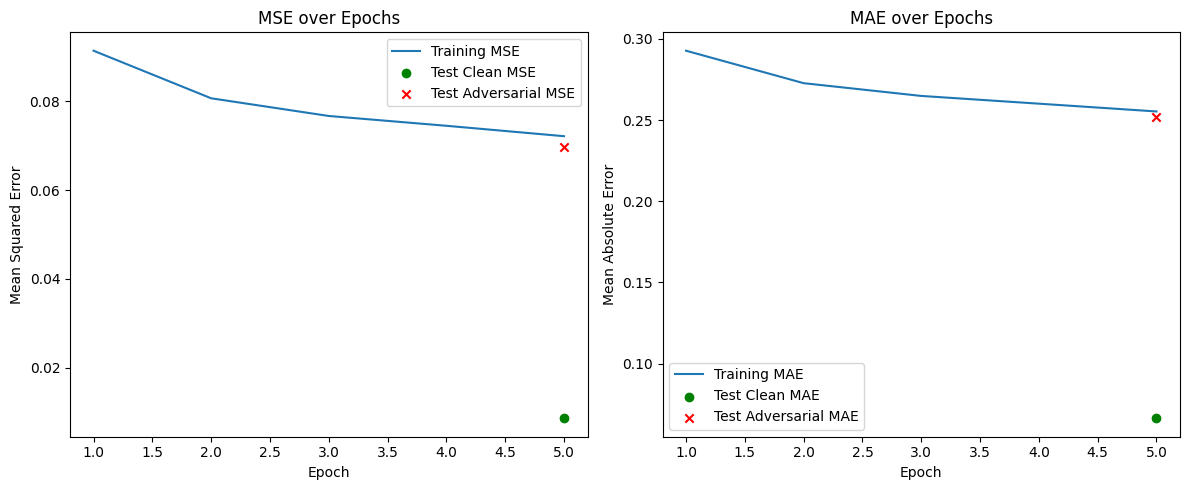

Training and test curves saved as 'training_test_curves.png'


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Load the pre-trained CNN+LSTM model
model = load_model('/content/best_cnn_lstm.keras')  # Replace with your model path

# Hyperparameters
epsilon = 0.05  # Max perturbation (L-inf norm)
alpha = 0.01    # Step size for PGD
num_iter = 10   # Number of PGD iterations
learning_rate = 1e-4  # Optimizer learning rate
epochs = 5      # Number of fine-tuning epochs

# Define PGD attack function (aligned with notebook)
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    x_adv = tf.identity(x)
    orig_x = x
    x_min = orig_x - epsilon
    x_max = orig_x + epsilon

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = MeanSquaredError()(y, pred)  # Use MeanSquaredError class
        grads = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grads)
        x_adv = tf.clip_by_value(x_adv, x_min, x_max)

    return x_adv

# Set up optimizer and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mse_loss_fn = MeanSquaredError()  # Use class for loss
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Lists to store training metrics
train_mse_history = []
train_mae_history = []

# Custom training loop with progress bar
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_mse = 0
    total_mae = 0
    num_batches = 0

    # Wrap train_dataset with tqdm for progress bar
    for x_batch, y_batch in tqdm(train_dataset, desc=f"Training Epoch {epoch+1}", unit="batch"):
        # Generate adversarial examples
        x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)

        # Compute loss and metrics on adversarial examples
        with tf.GradientTape() as tape:
            pred_adv = model(x_adv)
            mse_loss = mse_loss_fn(y_batch, pred_adv)

        # Update MAE metric
        mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
        mae_metric.update_state(y_batch, pred_adv)
        mae_value = mae_metric.result()

        # Backpropagate and update weights
        grads = tape.gradient(mse_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_mse += mse_loss.numpy()
        total_mae += mae_value.numpy()
        num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)
    print(f"Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}")

# Save the adversarially trained model
model.save('adversarially_trained_model.keras')
print("Model saved as 'adversarially_trained_model.keras'")

# Testing phase: Evaluate on clean and adversarial test data with progress bar
clean_mse = 0
clean_mae = 0
adv_mse = 0
adv_mae = 0
num_test_batches = 0

# Wrap test_dataset with tqdm for progress bar
for x_batch, y_batch in tqdm(test_dataset, desc="Testing", unit="batch"):
    # Clean data evaluation
    pred_clean = model(x_batch)
    clean_mse += mse_loss_fn(y_batch, pred_clean).numpy()
    mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
    mae_metric.update_state(y_batch, pred_clean)
    clean_mae += mae_metric.result().numpy()

    # Adversarial data evaluation
    x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)
    pred_adv = model(x_adv)
    adv_mse += mse_loss_fn(y_batch, pred_adv).numpy()
    mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
    mae_metric.update_state(y_batch, pred_adv)
    adv_mae += mae_metric.result().numpy()

    num_test_batches += 1

# Compute average test metrics
clean_mse /= num_test_batches
clean_mae /= num_test_batches
adv_mse /= num_test_batches
adv_mae /= num_test_batches

print("\nTest Results:")
print(f"Clean Data - MSE: {clean_mse:.4f}, MAE: {clean_mae:.4f}")
print(f"Adversarial Data - MSE: {adv_mse:.4f}, MAE: {adv_mae:.4f}")

# Plot training and test curves
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_mse_history, label='Training MSE')
plt.scatter([epochs], [clean_mse], color='green', label='Test Clean MSE', marker='o')
plt.scatter([epochs], [adv_mse], color='red', label='Test Adversarial MSE', marker='x')
plt.title('MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_mae_history, label='Training MAE')
plt.scatter([epochs], [clean_mae], color='green', label='Test Clean MAE', marker='o')
plt.scatter([epochs], [adv_mae], color='red', label='Test Adversarial MAE', marker='x')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.savefig('training_test_curves.png')
plt.show()
print("Training and test curves saved as 'training_test_curves.png'")

Epoch 1/100


Training Epoch 1: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0911, Average MAE: 0.2922, Validation MSE: 0.0081
New best validation MSE: 0.0081, saving weights
Epoch 2/100


Training Epoch 2: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0808, Average MAE: 0.2731, Validation MSE: 0.0083
No improvement in validation MSE, patience counter: 1/10
Epoch 3/100


Training Epoch 3: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0768, Average MAE: 0.2651, Validation MSE: 0.0087
No improvement in validation MSE, patience counter: 2/10
Epoch 4/100


Training Epoch 4: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0742, Average MAE: 0.2598, Validation MSE: 0.0090
No improvement in validation MSE, patience counter: 3/10
Epoch 5/100


Training Epoch 5: 100%|██████████| 567/567 [03:59<00:00,  2.37batch/s]


Average MSE: 0.0723, Average MAE: 0.2557, Validation MSE: 0.0106
No improvement in validation MSE, patience counter: 4/10
Epoch 6/100


Training Epoch 6: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0706, Average MAE: 0.2522, Validation MSE: 0.0081
No improvement in validation MSE, patience counter: 5/10
Epoch 7/100


Training Epoch 7: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0693, Average MAE: 0.2496, Validation MSE: 0.0088
No improvement in validation MSE, patience counter: 6/10
Epoch 8/100


Training Epoch 8: 100%|██████████| 567/567 [03:56<00:00,  2.39batch/s]


Average MSE: 0.0683, Average MAE: 0.2475, Validation MSE: 0.0090
No improvement in validation MSE, patience counter: 7/10
Epoch 9/100


Training Epoch 9: 100%|██████████| 567/567 [03:56<00:00,  2.40batch/s]


Average MSE: 0.0677, Average MAE: 0.2462, Validation MSE: 0.0076
New best validation MSE: 0.0076, saving weights
Epoch 10/100


Training Epoch 10: 100%|██████████| 567/567 [03:54<00:00,  2.42batch/s]


Average MSE: 0.0669, Average MAE: 0.2448, Validation MSE: 0.0091
No improvement in validation MSE, patience counter: 1/10
Epoch 11/100


Training Epoch 11: 100%|██████████| 567/567 [03:59<00:00,  2.37batch/s]


Average MSE: 0.0661, Average MAE: 0.2432, Validation MSE: 0.0077
No improvement in validation MSE, patience counter: 2/10
Epoch 12/100


Training Epoch 12: 100%|██████████| 567/567 [04:01<00:00,  2.35batch/s]


Average MSE: 0.0655, Average MAE: 0.2418, Validation MSE: 0.0095
No improvement in validation MSE, patience counter: 3/10
Epoch 13/100


Training Epoch 13: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0653, Average MAE: 0.2416, Validation MSE: 0.0090
No improvement in validation MSE, patience counter: 4/10
Epoch 14/100


Training Epoch 14: 100%|██████████| 567/567 [03:58<00:00,  2.38batch/s]


Average MSE: 0.0644, Average MAE: 0.2397, Validation MSE: 0.0096
No improvement in validation MSE, patience counter: 5/10
Epoch 15/100


Training Epoch 15: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0640, Average MAE: 0.2388, Validation MSE: 0.0086
No improvement in validation MSE, patience counter: 6/10
Epoch 16/100


Training Epoch 16: 100%|██████████| 567/567 [03:59<00:00,  2.36batch/s]


Average MSE: 0.0634, Average MAE: 0.2376, Validation MSE: 0.0088
No improvement in validation MSE, patience counter: 7/10
Epoch 17/100


Training Epoch 17: 100%|██████████| 567/567 [04:00<00:00,  2.36batch/s]


Average MSE: 0.0627, Average MAE: 0.2363, Validation MSE: 0.0081
No improvement in validation MSE, patience counter: 8/10
Epoch 18/100


Training Epoch 18: 100%|██████████| 567/567 [04:21<00:00,  2.16batch/s]


Average MSE: 0.0623, Average MAE: 0.2355, Validation MSE: 0.0096
No improvement in validation MSE, patience counter: 9/10
Epoch 19/100


Training Epoch 19: 100%|██████████| 567/567 [03:56<00:00,  2.39batch/s]


Average MSE: 0.0619, Average MAE: 0.2346, Validation MSE: 0.0082
No improvement in validation MSE, patience counter: 10/10
Early stopping triggered after 19 epochs
Model saved as 'adversarially_trained_model_CNN_LSTM.keras'


Testing: 100%|██████████| 142/142 [00:52<00:00,  2.70batch/s]



Test Results:
Clean Data - MSE: 0.0076, MAE: 0.0655
Adversarial Data - MSE: 0.0650, MAE: 0.2435


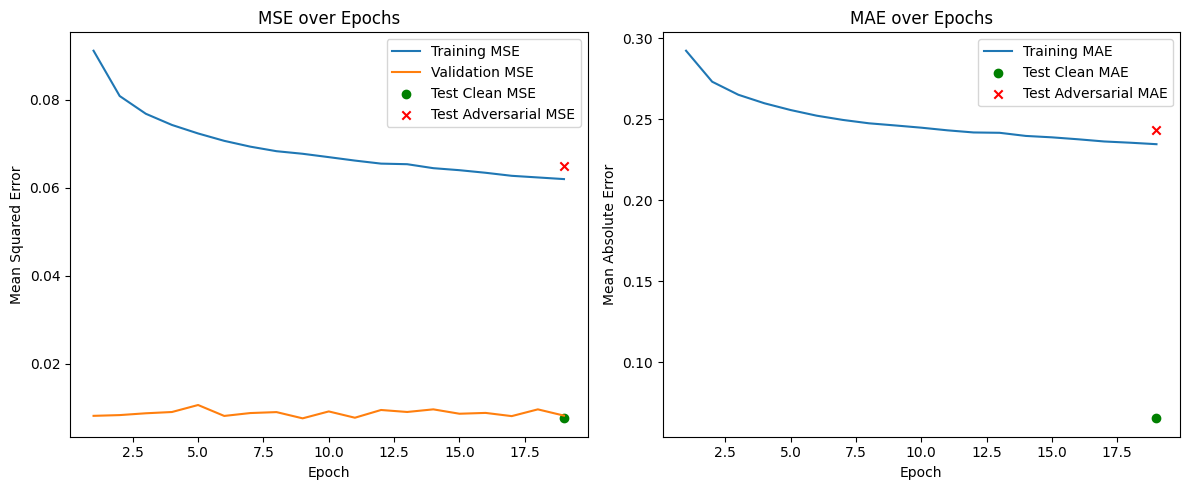

Training and test curves saved as 'training_test_curves.png'


In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np

# Load the pre-trained CNN+LSTM model
model = load_model('/content/best_cnn_lstm.keras')  # Replace with your model path

# Hyperparameters
epsilon = 0.05  # Max perturbation (L-inf norm)
alpha = 0.01    # Step size for PGD
num_iter = 10   # Number of PGD iterations
learning_rate = 1e-4  # Optimizer learning rate
epochs = 100    # Increased from 5 to 100
patience = 10   # Early stopping patience
min_delta = 0.0001  # Minimum change in validation loss to qualify as improvement

# Define PGD attack function (aligned with notebook)
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    x_adv = tf.identity(x)
    orig_x = x
    x_min = orig_x - epsilon
    x_max = orig_x + epsilon

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = MeanSquaredError()(y, pred)  # Use MeanSquaredError class
        grads = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grads)
        x_adv = tf.clip_by_value(x_adv, x_min, x_max)

    return x_adv

# Set up optimizer and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mse_loss_fn = MeanSquaredError()  # Use class for loss
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Lists to store training and validation metrics
train_mse_history = []
train_mae_history = []
val_mse_history = []

# Early stopping variables
best_val_mse = float('inf')
best_weights = None
patience_counter = 0

# Custom training loop with progress bar and early stopping
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_mse = 0
    total_mae = 0
    num_batches = 0

    # Wrap train_dataset with tqdm for progress bar
    for x_batch, y_batch in tqdm(train_dataset, desc=f"Training Epoch {epoch+1}", unit="batch"):
        # Generate adversarial examples
        x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)

        # Compute loss and metrics on adversarial examples
        with tf.GradientTape() as tape:
            pred_adv = model(x_adv)
            mse_loss = mse_loss_fn(y_batch, pred_adv)

        # Update MAE metric
        mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
        mae_metric.update_state(y_batch, pred_adv)
        mae_value = mae_metric.result()

        # Backpropagate and update weights
        grads = tape.gradient(mse_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_mse += mse_loss.numpy()
        total_mae += mae_value.numpy()
        num_batches += 1

    # Compute average training metrics
    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)

    # Compute validation MSE on test_dataset
    val_mse = 0
    num_val_batches = 0
    for x_val, y_val in test_dataset:
        pred_val = model(x_val)
        val_mse += mse_loss_fn(y_val, pred_val).numpy()
        num_val_batches += 1
    val_mse /= num_val_batches
    val_mse_history.append(val_mse)

    print(f"Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Validation MSE: {val_mse:.4f}")

    # Early stopping logic
    if val_mse < best_val_mse - min_delta:
        best_val_mse = val_mse
        best_weights = model.get_weights()  # Save best weights
        patience_counter = 0
        print(f"New best validation MSE: {best_val_mse:.4f}, saving weights")
    else:
        patience_counter += 1
        print(f"No improvement in validation MSE, patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        model.set_weights(best_weights)  # Restore best weights
        break

# Save the adversarially trained model
model.save('adversarially_trained_model.keras')
print("Model saved as 'adversarially_trained_model_CNN_LSTM.keras'")

# Testing phase: Evaluate on clean and adversarial test data with progress bar
clean_mse = 0
clean_mae = 0
adv_mse = 0
adv_mae = 0
num_test_batches = 0

# Wrap test_dataset with tqdm for progress bar
for x_batch, y_batch in tqdm(test_dataset, desc="Testing", unit="batch"):
    # Clean data evaluation
    pred_clean = model(x_batch)
    clean_mse += mse_loss_fn(y_batch, pred_clean).numpy()
    mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
    mae_metric.update_state(y_batch, pred_clean)
    clean_mae += mae_metric.result().numpy()

    # Adversarial data evaluation
    x_adv = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iter)
    pred_adv = model(x_adv)
    adv_mse += mse_loss_fn(y_batch, pred_adv).numpy()
    mae_metric.reset_state()  # Use reset_state() for TensorFlow 2.6+
    mae_metric.update_state(y_batch, pred_adv)
    adv_mae += mae_metric.result().numpy()

    num_test_batches += 1

# Compute average test metrics
clean_mse /= num_test_batches
clean_mae /= num_test_batches
adv_mse /= num_test_batches
adv_mae /= num_test_batches

print("\nTest Results:")
print(f"Clean Data - MSE: {clean_mse:.4f}, MAE: {clean_mae:.4f}")
print(f"Adversarial Data - MSE: {adv_mse:.4f}, MAE: {adv_mae:.4f}")

# Plot training, validation, and test curves
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_mse_history)+1), train_mse_history, label='Training MSE')
plt.plot(range(1, len(val_mse_history)+1), val_mse_history, label='Validation MSE')
plt.scatter([len(train_mse_history)], [clean_mse], color='green', label='Test Clean MSE', marker='o')
plt.scatter([len(train_mse_history)], [adv_mse], color='red', label='Test Adversarial MSE', marker='x')
plt.title('MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_mae_history)+1), train_mae_history, label='Training MAE')
plt.scatter([len(train_mae_history)], [clean_mae], color='green', label='Test Clean MAE', marker='o')
plt.scatter([len(train_mae_history)], [adv_mae], color='red', label='Test Adversarial MAE', marker='x')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.savefig('training_test_curves.png')
plt.show()
print("Training and test curves saved as 'training_test_curves.png'")